## Day 11 불러오기

In [12]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.1
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [13]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [14]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform = ToTensor()
)

In [15]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)  # 32의 샘플식 
train_dataloader = DataLoader(train_data,
        batch_size = BATCH_SIZE,
        shuffle = True)

test_dataloader = DataLoader(test_data,
        batch_size = BATCH_SIZE,
        shuffle = False)# don't necessarily have to shuffle the testing data

#Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002DD7FE0CE60>, <torch.utils.data.dataloader.DataLoader object at 0x000002DD7FDD4FB0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [16]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
#dir(train_dataloader)#dir: 객체 메서드 확인  #값을 이터레이터로 만들고 next 메서드를 호출해 요소를 차례대로 꺼내기
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0] #BATCH_SIZE 로 묶은 32 개의 샘플 중 가장 첫 번째 

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")  #nn.Linear() layers like their inputs to be in the form of feature vectors.

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

In [19]:
# We've got a baseline model class we can use, now let's instantiate a model. 기준모델이 있으니 모델을 인스턴스화 하기

torch.manual_seed(42)


# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784,
        hidden_units = 10, # how many units in the hidden layer
        output_shape = len(class_names)) # one for every class

model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


In [21]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


### 3.2 실험 시간을 측정하는 함수 생성
- cpu 와 gpu 실험 시간 측정
- Our timing function will import the timeit.default_timer() function from the Python timeit module.

In [22]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

In [23]:
# Import tqdm for progress bar  #진행 줄 표시 가지고 오기
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 에포크 당 손실을 노적적으로 합산한다.
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
        # Divide total train loss by length of train dataloader (average loss per batch per epoch)  에포크당 베치당 평균 손실 
    train_loss /= len(train_dataloader)
        
        ### Testing
        # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0
        
    model_0.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
                
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch
                
            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true = y, y_pred=test_pred.argmax(dim = 1))
                
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

c:\Users\sjiyun\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:10<00:21, 10.65s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:21<00:10, 10.72s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:32<00:00, 10.81s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 32.447 seconds


In [24]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [25]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [27]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [28]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

### 6.2 Functionizing(함수화하기) training and test loops

In [29]:
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0,0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU  여기서 GPU로 데이터 보내기
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0,0
    model.to(device)
    model.eval()   # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
    


In [30]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as Timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(data_loader = train_dataloader,
               model = model_1,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn = accuracy_fn)
    test_step(data_loader = test_dataloader,
              model=model_1,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.09199 | Train accuracy: 61.34%


 33%|███▎      | 1/3 [00:15<00:31, 15.83s/it]

Epoch: 1
--------
Train loss: 0.78101 | Train accuracy: 71.93%


 67%|██████▋   | 2/3 [00:30<00:15, 15.23s/it]

Epoch: 2
--------
Train loss: 0.67027 | Train accuracy: 75.94%


100%|██████████| 3/3 [00:45<00:00, 15.10s/it]

Train time on cuda: 45.300 seconds


In [31]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [32]:
# Check baseline results
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 7. 모델 2: 합성곱 신경망(CNN) 구축 Convolution Neural Network
- we'll leverage the nn.Conv2d() and nn.MaxPool2d() layers from torch.nn

In [43]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Stepping through nn.Conv2d()

-nn.Conv2d(), also known as a convolutional layer. 합성곱 계층
- nn.MaxPool2d(), also known as a max pooling layer. 풀링 계층(입력 features map에 가장 큰값 반환)

In [45]:
# 레이아웃을 테스트하기 위해 장난감 데이터 만들기
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

- nn.Conv2d()다양한 매개변수를 사용하여 예를 만들어 보겠습니다 .

- in_channels(정수) - 입력 이미지의 채널 수.
- out_channels(정수) - 합성곱에 의해 생성된 채널 수.
- kernel_size(정수 또는 튜플) - 합성 커널/필터의 크기입니다. (한 번에 처리하는)
- stride(정수 또는 튜플, 선택 사항) - 컨볼루션 커널이 한 번에 처리하는 단계의 크기입니다. 기본값: 1.  2로 바뀌면 두 칸씨 뜀
- padding(정수, 튜플, 문자열) - 입력의 네 변에 패딩을 추가합니다. 하나씩 더 늘어남 6,6 행렬은 8,8행렬로로 기본값: 0.

In [46]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG 
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here 

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input) 

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [47]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [48]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [49]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

### 7.2 Stepping through nn.MaxPool2d()

In [50]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [51]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for model_2

In [52]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [53]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60672 | Train accuracy: 78.02%


 33%|███▎      | 1/3 [00:20<00:40, 20.01s/it]

Epoch: 1
---------
Train loss: 0.36369 | Train accuracy: 86.94%


 67%|██████▋   | 2/3 [00:38<00:19, 19.22s/it]

Epoch: 2
---------
Train loss: 0.32517 | Train accuracy: 88.17%


100%|██████████| 3/3 [00:57<00:00, 19.20s/it]

Train time on cuda: 57.609 seconds


In [56]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32959723472595215,
 'model_acc': 88.32867412140575}

## 3개의 모델 비교 cpu, GPU, CNN

In [57]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.329597,88.328674


In [58]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,32.447423
1,FashionMNISTModelV1,0.685001,75.019968,45.299830
2,FashionMNISTModelV2,0.329597,88.328674,57.609076


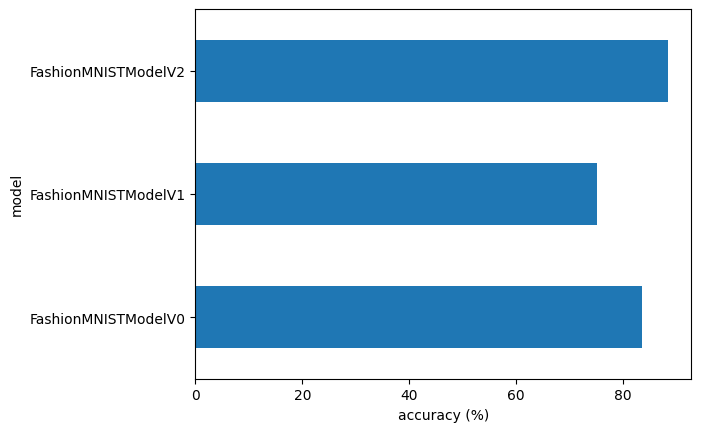

In [59]:
#시각화 
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 가장 좋은 모델로 예측해보자

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device  #batch자리에 sample 하나를 추가

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())  #CPU로 pred_prob 넣기 
            #지금 pred_probs는 리스트 형태로 1D 형태로 있다. 이걸 stack을 쌓아서 
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [61]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [ ]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# Make predictions on test samples with model 2
pred_probs[:2]  #now we can go from prediction probabilities to prediction 
                #labels by taking the torch.argmax() of the output of the torch.softmax() activation function.

tensor([[2.1506e-06, 7.5605e-08, 2.3472e-07, 1.1333e-07, 1.6591e-08, 9.9835e-01,
         1.0641e-05, 3.5628e-05, 4.9589e-05, 1.5481e-03],
        [8.5096e-02, 4.1618e-01, 4.6045e-04, 1.9818e-01, 1.7446e-01, 9.3681e-04,
         1.2321e-01, 2.3952e-04, 1.1416e-03, 8.6775e-05]])

In [63]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [64]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

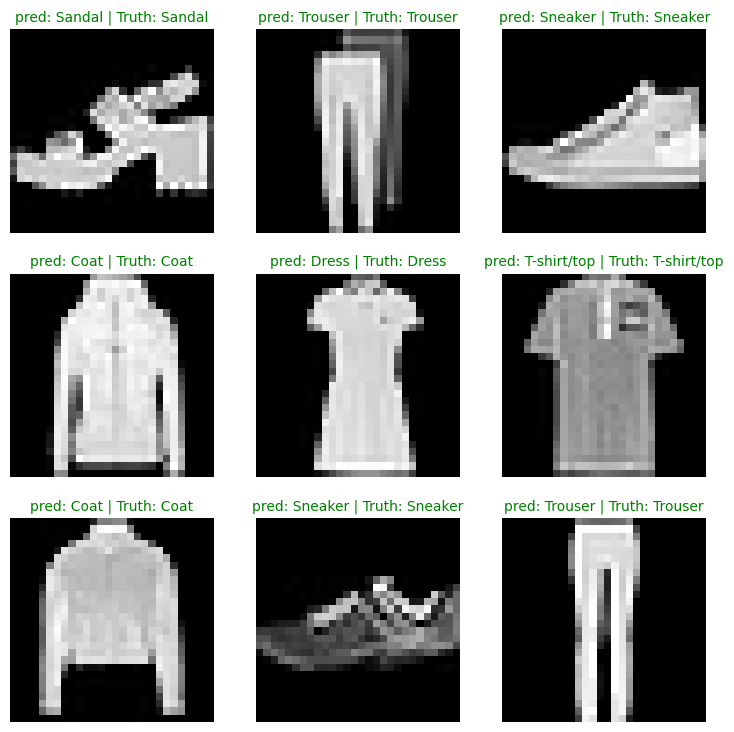

In [67]:
# Plot predictions
plt.figure(figsize =(9,9))
nrows =3
ncols =3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows,ncols,i+1)
    
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap ='gray')
    
    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]
    
    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]
    
    # Create the title text of the plot
    title_text = f'pred: {pred_label} | Truth: {truth_label}'
    
    # 동일성 체크 후에 그에 따라(accordingly) 제목 컬러 설정
    if pred_label == truth_label:
        plt.title(title_text, fontsize =10, c="g")# green text if correct
    else:
        plt.title(title_text, fontsize = 10, c='r')
    plt.axis(False) #plt.axis(False)는 Matplotlib에서 그래프의 축(눈금, 테두리 등) 제거 
    
    

## 10. Making a confusion matrix for further prediction evaluation

- To make a confusion matrix, we'll go through three steps:

- Make predictions with our trained model, model_2 (a confusion matrix compares predictions to true labels).
- Make a confusion matrix using torchmetrics.ConfusionMatrix.
- Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix().

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc = "Making predictions"):
        # Send data and targets to target device
        X,y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit,dim =1).argmax(dim =1)  # 배치 차원이 아니라 로직 차원에서 소프트맥스 함수를 사용하므로 dim=1(행)으로 계산
        #Put predictions on CPU for evaluation                 # dim = 0(열) 계산은 배치 사이즈로 계산이 되는 경우다. 
        y_preds.append(y_pred.cpu())
       
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)   # cat = 파이토치에는 concat이란 함수는 없다. 대신 같은 기능인 cat이 있다. 
print(y_pred_tensor)#예측 레이블           # concatenate(합치다) 란 뜻으로 dim(차원)을 설정하여 합칠 수 있다. 기본(0): 열로 붙이기, 1: (행 붙이기)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 174.88it/s]

tensor([9, 2, 1,  ..., 8, 1, 5])


In [78]:
s = torch.tensor([[0.2,0.2,0.3],[0.3,0.4,0.5]])
print(s.shape)
k= torch.softmax(s,dim =1)
print(k) 

torch.Size([2, 3])
tensor([[0.3220, 0.3220, 0.3559],
        [0.3006, 0.3322, 0.3672]])


In [ ]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher
# assert 확신하다 "이 조건은 무조건 참이어야 한다는 뜻"

0.23.4


tensor([[861,   1,  15,  34,   5,   2,  73,   0,   9,   0],
        [  0, 976,   0,  15,   3,   0,   2,   0,   4,   0],
        [ 16,   1, 765,   8, 119,   0,  90,   0,   1,   0],
        [ 19,   5,  10, 905,  24,   0,  36,   0,   1,   0],
        [  1,   3,  51,  32, 830,   0,  83,   0,   0,   0],
        [  1,   0,   0,   0,   0, 977,   0,  15,   3,   4],
        [166,   2,  72,  30,  80,   0, 634,   0,  16,   0],
        [  0,   0,   0,   0,   0,  23,   0, 953,   0,  24],
        [  1,   1,   4,   3,   5,   2,   4,   4, 976,   0],
        [  0,   0,   0,   0,   0,   9,   0,  36,   1, 954]])


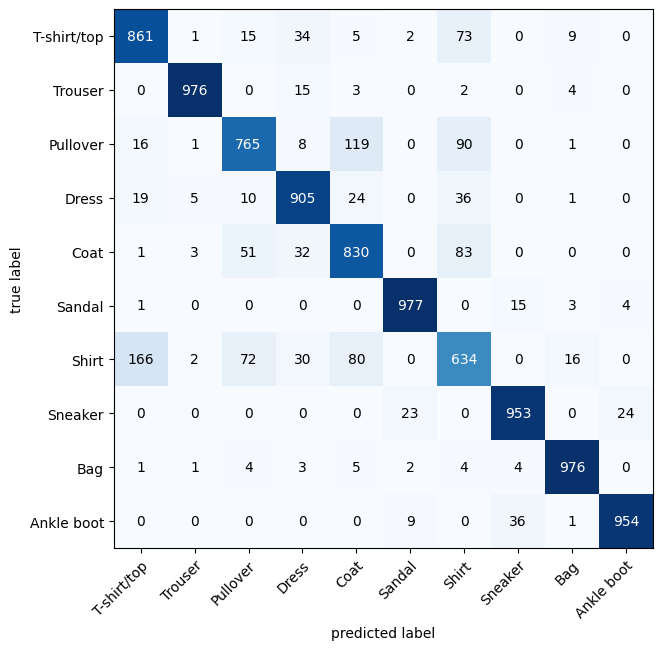

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
#confusion matrix 는 모델이 특정 부분에 혼란을 겪고 있다는 것을 알 수 있다
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)
print(confmat_tensor)
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,  # turn the row and column labels into class names
    figsize = (10,7)   
)

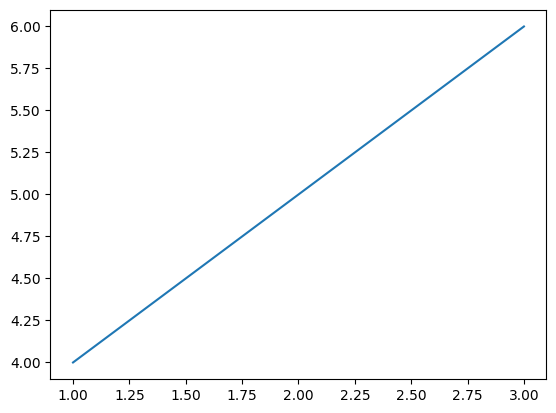

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot([1, 2, 3], [4, 5, 6])  # ax를 통해 그래프를 그림

plt.show()


## 11. Save and load best performing mode

1. torch.save - a function to save a whole PyTorch model or a model's state_dict().
2. torch.load - a function to load in a saved PyTorch object.
3. torch.nn.Module.load_state_dict() - a function to load a saved state_dict() into an existing model instance.

In [ ]:
from pathlib import Path
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models") #폴더 경로 만들기
MODEL_PATH.mkdir(parents = True,  # create parent directories if needed  폴더 경로가 있으면 안 해도 되고 없으면 폴더 만들기
                 exist_ok = True) # if models directory already exists, don't error

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME  #최종적으로 /models/03_pytorch_computer_vision_model_2.pth 여기에 저장됨

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(), # 학습시켰던 레이어 이름과 파라미터들(가중치, 편향 등) 만 저장됨 전체 모델은 다시 불러 와야 함함
           f = MODEL_SAVE_PATH)  # MODEL_SAVE_PATH이 경로로 저장한다.

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [93]:
# we'll need to create a new instance of FashionMNISTModelV2() with the same input parameters as our saved model state_dict().
loaded_model_2 = FashionMNISTModelV2(input_shape =1,
                                     hidden_units = 10,
                                     output_shape = 10)

# Load in the saved state_dict()
#이런식으로 저장한 것을 불러오는 구나 근데 바로 gpu 로 보낼 수 있다는 게 놀랍다 순서도 중요
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)



In [95]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model = loaded_model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

loaded_model_2_results 

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32959723472595215,
 'model_acc': 88.32867412140575}

In [96]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32959723472595215,
 'model_acc': 88.32867412140575}

In [ ]:
# 오차가 허용 범위인지 구하기 허용하면 True 
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']),
              atol= 1e-08, #abolute tolerance
              rtol = 0.0001) # relative tolerance